In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

## Data

In [2]:
!pip install -q ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

def get_data_from_uci(id=144):
    statlog_german_credit_data = fetch_ucirepo(id=144)

    X = statlog_german_credit_data.data.features
    y = statlog_german_credit_data.data.targets

    return X, y

X, y = get_data_from_uci(144)

In [4]:
X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


In [5]:
le = [
    'Attribute1',
    'Attribute3',
    'Attribute4',
    'Attribute6',
    'Attribute7',
    'Attribute9',
    'Attribute10',
    'Attribute12',
    'Attribute14',
    'Attribute15',
    'Attribute17',
    'Attribute19',
    'Attribute20',
]

## Benchmarks

In [6]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
bX, by = X.copy(), y.copy()

label_enc = LabelEncoder()
label_enc.fit(bX[le].to_numpy().flatten())
for col in le:
    bX.loc[:, (col)] = label_enc.transform(bX[col])

norm = StandardScaler()
norm.fit(bX)
bX = pd.DataFrame(data=norm.transform(bX), columns=bX.columns)

# norm = RobustScaler()
# norm.fit(bX)
# bX = pd.DataFrame(data=norm.transform(bX), columns=bX.columns)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(bX, by, test_size=0.33,
                                                    random_state=42)

In [17]:
def get_benchmarks():
    benchmarks_acc = {}

    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, y_train.to_numpy().ravel())
    benchmarks_acc['LogReg'] = accuracy_score(y_test, clf.predict(X_test))

    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train.to_numpy().ravel())
    benchmarks_acc['KNN'] = accuracy_score(y_test, neigh.predict(X_test))

    rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
    rf.fit(X_train, y_train.to_numpy().ravel())
    benchmarks_acc['RandForest'] = accuracy_score(y_test, rf.predict(X_test))

    return pd.DataFrame(data=benchmarks_acc.values(),
                        index=benchmarks_acc.keys(),
                        columns=['Accuracy'])


In [18]:
get_benchmarks()

,Accuracy
LogReg,0.766667
KNN,0.760606
RandForest,0.760606


## K-means

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(X[le].to_numpy().flatten())

for col in le:
    X.loc[:, (col)] = label_enc.transform(X[col])


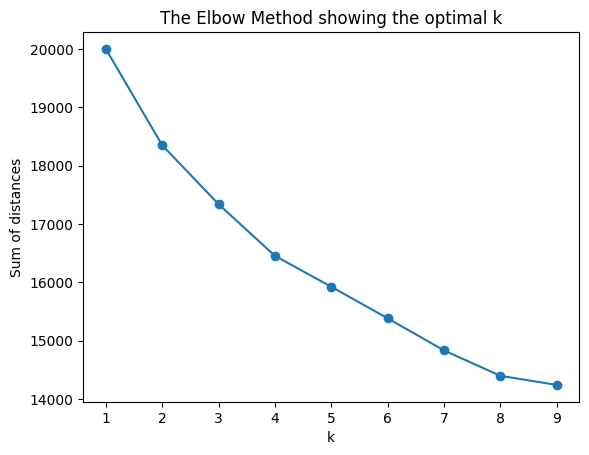

In [ ]:
norm = StandardScaler()
norm.fit(X)
df = norm.transform(X)

K = range(1, 10)
models = [KMeans(n_clusters=k).fit(df) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
norm = StandardScaler()
DATA = {
    'all data': norm.fit_transform(X),
    'without label encoder data': norm.fit_transform(X.loc[:, ~X.columns.isin(le)]),
    'only label encoder data': norm.fit_transform(X[le])
}

robust = RobustScaler()
robust_DATA = {
    'all data': robust.fit_transform(X),
    'without label encoder data': robust.fit_transform(X.loc[:, ~X.columns.isin(le)]),
    'only label encoder data': robust.fit_transform(X[le])
}

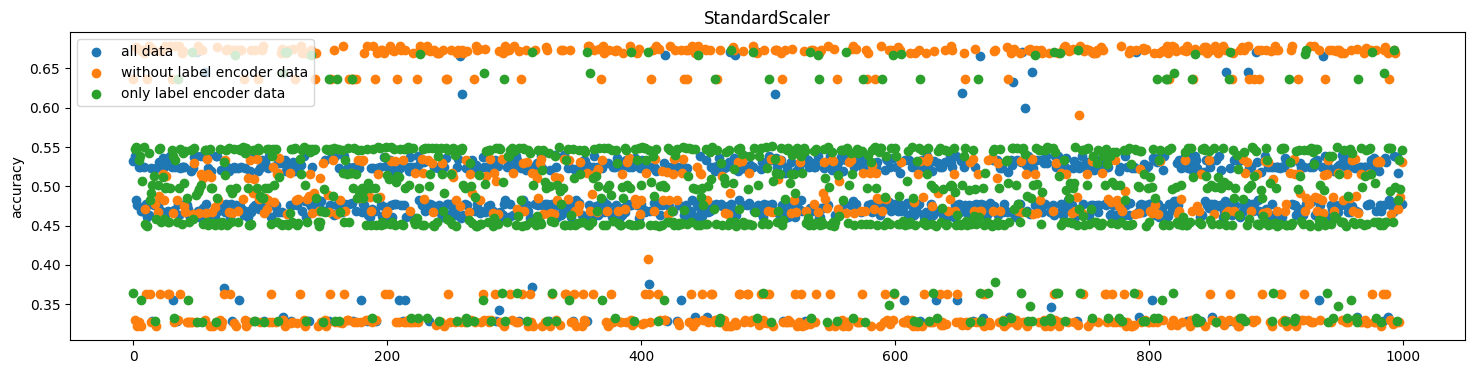

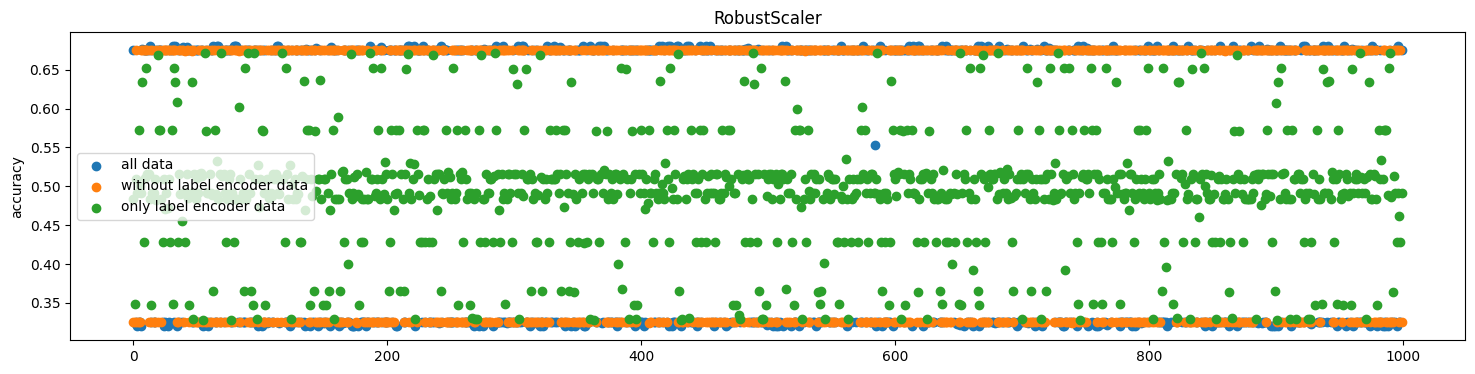

In [ ]:
acc_results = {
    'StandardScaler': defaultdict(list),
    'RobustScaler': defaultdict(list),
}

model = KMeans(n_clusters=2)


plt.figure(figsize=(18, 4))
for key, data in DATA.items():
    for _ in range(1_000):
        model.fit(data)
        acc_results['StandardScaler'][key].append(accuracy_score(y, model.labels_+1))

    plt.scatter(np.arange(1_000), acc_results['StandardScaler'][key], label=key)

plt.title('StandardScaler')
plt.ylabel('accuracy')
plt.legend()


plt.figure(figsize=(18, 4))
for key, data in robust_DATA.items():
    for _ in range(1_000):
        model.fit(data)
        acc_results['RobustScaler'][key].append(accuracy_score(y, model.labels_+1))

    plt.scatter(np.arange(1_000), acc_results['RobustScaler'][key], label=key)

plt.title('RobustScaler')
plt.ylabel('accuracy')
plt.legend()


In [ ]:
for scaler, results in acc_results.items():
    print(scaler)
    for key, value in results.items():
        print(key)
        print(f'max: {np.max(value)}, min: {np.min(value)}, median: {round(np.mean(value), 4)}')
        print('='*50)
    print()

StandardScaler
all data
max: 0.671, min: 0.329, median: 0.4913
without label encoder data
max: 0.678, min: 0.322, median: 0.4884
only label encoder data
max: 0.673, min: 0.327, median: 0.4902

RobustScaler
all data
max: 0.68, min: 0.32, median: 0.5065
without label encoder data
max: 0.675, min: 0.324, median: 0.5406
only label encoder data
max: 0.672, min: 0.328, median: 0.4937

